# Graph Tutorial - Part 1: Representations & Traversal


# PART 0: SETUP & NETWORK GENERATION

## 0.1 Imports

In [1]:
# ▶ RUN THIS CELL: Import required libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for 
# \reproducibility
np.random.seed(42)

# Figure settings for presentation-quality plots
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 16

# Import shared plotting utilities
from plots import visualize_graph, plot_adjacency_matrix, IPYSIGMA_AVAILABLE, PLOTLY_AVAILABLE

if IPYSIGMA_AVAILABLE:
    print('✓ ipysigma available for interactive graph visualization')
if PLOTLY_AVAILABLE:
    print('✓ plotly available for interactive matrix visualization')

print('✓ Imports successful!')

✓ ipysigma available for interactive graph visualization
✓ plotly available for interactive matrix visualization
✓ Imports successful!


## 0.2 Load Connectome Data

We'll load synapse data from the **FAFB** (Full Adult Fly Brain) dataset, specifically the **central complex** region.

The data contains synaptic connections with columns:
- `pre`: presynaptic neuron ID
- `post`: postsynaptic neuron ID
- `side`: hemisphere (left/right)


In [2]:
# ▶ RUN THIS CELL: Load connectome data
import os
import pandas as pd

# Configuration
DATASET = 'fafb_783'
REGION = 'central_complex'

# Try local path first, then GCS
LOCAL_PATH = f'data/{DATASET}_{REGION}_synapses.feather'
GCS_PATH = f'gs://sjcabs_2025_data/fafb/{REGION}/{DATASET}_{REGION}_synapses.feather'
META_PATH = f'gs://sjcabs_2025_data/fafb/{REGION}/{DATASET}_{REGION}_meta.feather'

if os.path.exists(LOCAL_PATH):
    print(f'Loading from local: {LOCAL_PATH}')
    synapses_df = pd.read_feather(LOCAL_PATH)
else:
    print(f'Loading from GCS: {GCS_PATH}')
    import gcsfs
    gcs = gcsfs.GCSFileSystem(token='google_default')
    import pyarrow.feather as feather
    with gcs.open(GCS_PATH.replace('gs://', ''), 'rb') as f:
        synapses_df = feather.read_feather(f)
    with gcs.open(META_PATH.replace('gs://', ''), 'rb') as f:
        meta_df = feather.read_feather(f)

print(f'✓ Loaded {len(synapses_df):,} synapses')
print(f'  Columns: {list(synapses_df.columns)}')
synapses_df.head()


Loading from GCS: gs://sjcabs_2025_data/fafb/central_complex/fafb_783_central_complex_synapses.feather
✓ Loaded 1,820,042 synapses
  Columns: ['id', 'connector_id', 'x', 'y', 'z', 'confidence', 'syn_top_nt', 'syn_top_p', 'gaba', 'acetylcholine', 'glutamate', 'octopamine', 'serotonin', 'dopamine', 'prepost', 'pre', 'post', 'neuropil', 'pre_label', 'post_label', 'side']


id connector_id       x       y       z  confidence     syn_top_nt  \
0   37903271   8415165437  435587  268526  197920         142       dopamine   
1   38453376   8415165437  440918  258788  197240         132  acetylcholine   
2  133622988   4758879023  430782  250449  104440         137  acetylcholine   
3  171205160   8415165437  442883  253256  200480          63  acetylcholine   
4   40090700   5005274937  560716  178635  129400         157  acetylcholine   

   syn_top_p  gaba  acetylcholine  ...  octopamine  serotonin  dopamine  \
0       0.49  0.02           0.31  ...        0.00       0.14      0.49   
1       0.87  0.03           0.87  ...        0.01       0.02      0.07   
2       0.97  0.00           0.97  ...        0.02       0.00      0.01   
3       0.98  0.00           0.98  ...        0.00       0.00      0.01   
4       0.97  0.00           0.97  ...        0.00       0.00      0.03   

   prepost                 pre                post neuropil pre_label  \
0        0  720575940602430944  720575940621854563      IPS      axon   
1        0  720575940602430944  720575940631537735      IPS      axon   
2        0  720575940602430944  720575940624323475      LAL      axon   
3        0  720575940602430944  720575940631537735      IPS      axon   
4        0  720575940602747360  720575940613326250       FB      axon   

  post_label   side  
0       axon  right  
1       axon  right  
2    unknown  right  
3       axon  right  
4   dendrite   None  

[5 rows x 21 columns]

In [3]:
# ▶ RUN THIS CELL: Build NetworkX graph from synapse data

# Create directed graph from synapse data
# Each row is a synapse: pre -> post
G_connectome = nx.DiGraph()

# Add edges (multiple synapses between same neurons become edge weight)
edge_counts = synapses_df.groupby(['pre', 'post']).size().reset_index(name='weight')
for _, row in edge_counts.iterrows():
    G_connectome.add_edge(row['pre'], row['post'], weight=row['weight'])

print(f'✓ Built connectome graph')
print(f'  Nodes: {G_connectome.number_of_nodes():,}')
print(f'  Edges: {G_connectome.number_of_edges():,}')
print(f'  Density: {nx.density(G_connectome):.4f}')

# Store density for later use
CONNECTOME_DENSITY = nx.density(G_connectome)


✓ Built connectome graph
  Nodes: 10,572
  Edges: 340,036
  Density: 0.0030


In [4]:
# Add node attributes from graph structure
nx.set_node_attributes(G_connectome, dict(G_connectome.degree()), 'degree')
nx.set_node_attributes(G_connectome, dict(G_connectome.in_degree()), 'in_degree')
nx.set_node_attributes(G_connectome, dict(G_connectome.out_degree()), 'out_degree')

# Add node attributes from metadata
# Columns to include: side, hemilineage, cell_class, cell_type, neurotransmitter_prediction
META_COLUMNS = ['side', 'hemilineage', 'cell_class', 'cell_type', 'neurotransmitter_predicted']
ID_COLUMN = f'{DATASET}_id'  # e.g., 'fafb_783_id'

# Create mapping from neuron ID to metadata
meta_dict = meta_df.set_index(ID_COLUMN)[META_COLUMNS].to_dict('index')

# Add each metadata column as node attribute
n_labeled = 0
for col in META_COLUMNS:
    attr_dict = {}
    for node in G_connectome.nodes():
        if node in meta_dict:
            attr_dict[node] = meta_dict[node].get(col)
            if col == META_COLUMNS[0] and meta_dict[node].get(col) is not None:
                n_labeled += 1
        else:
            attr_dict[node] = None
    nx.set_node_attributes(G_connectome, attr_dict, col)

print(f'✓ Node attributes set:')
print(f'  Structural: degree, in_degree, out_degree')
print(f'  Metadata: {", ".join(META_COLUMNS)}')
print(f'  Neurons with metadata: {n_labeled:,} / {G_connectome.number_of_nodes():,} ({n_labeled/G_connectome.number_of_nodes()*100:.1f}%)')

✓ Node attributes set:
  Structural: degree, in_degree, out_degree
  Metadata: side, hemilineage, cell_class, cell_type, neurotransmitter_predicted
  Neurons with metadata: 2,783 / 10,572 (26.3%)


# PART 1: GRAPH REPRESENTATIONS

In [ ]:
# Display the Central Complex anatomy from FAFB
from IPython.display import Image
Image('imgs/CX_FAFB.png', width=1000)

In [26]:
# Interactive network visualization using ipysigma
# visualize_graph is imported from plots.py
# Available color attributes: side, hemilineage, cell_class, cell_type, neurotransmitter_predicted

# Color by cell_type (nodes with null values shown in gray)
print('Color by: cell_type | Size by: degree')
display(visualize_graph(G_connectome, node_color_attr='cell_type', node_size_attr='degree', max_categorical_colors=30))

Color by: cell_type | Size by: degree


Sigma(nx.DiGraph with 10,572 nodes and 340,036 edges)

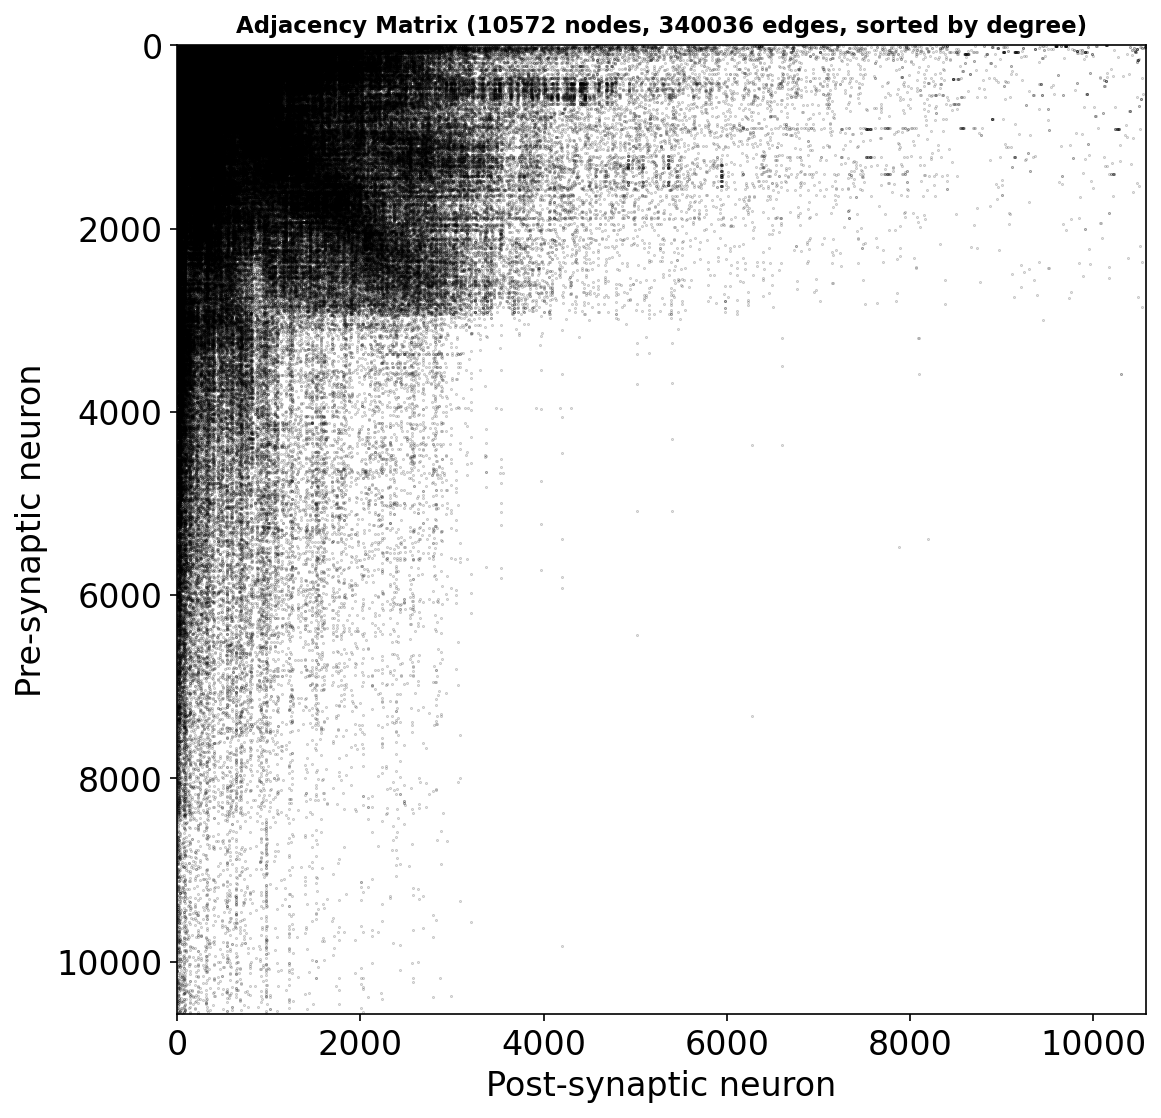

In [25]:
# plot_adjacency_matrix is now imported from plots.py
# See plots.py for the full implementation

# Sort by cell_type
plot_adjacency_matrix(G_connectome, sort_by='degree');

# PART 2: NEIGHBORHOOD TRAVERSAL

**Take-home:** Local traversal explodes exponentially - you reach most of the network in 3-4 hops.

Small-world networks are particularly interesting here because of their short average path length.

In [7]:
# Helper function for k-hop reachability analysis
def k_hop_reachability(G, start_node, max_k=5):
    """Compute nodes reachable at each k-hop distance (undirected)."""
    get_neighbors = lambda n: set(G.successors(n)) | set(G.predecessors(n))
    reachable = {start_node}
    results = {0: 1}
    for k in range(1, max_k + 1):
        new_reachable = set()
        for node in reachable:
            new_reachable.update(get_neighbors(node))
        reachable.update(new_reachable)
        results[k] = len(reachable)
    return results


print('✓ Helper functions defined!')

✓ Helper functions defined!


In [8]:
def generate_small_world_network(n=20, k=4, p=0.3, seed=42):
    """
    Generate a Watts-Strogatz small-world network.
    
    Parameters:
    - n: number of nodes
    - k: each node is connected to k nearest neighbors in ring topology
    - p: probability of rewiring each edge
    
    The resulting graph has:
    - High clustering coefficient (local structure preserved)
    - Short average path length (random shortcuts)
    
    We convert to DiGraph and add random edge weights.
    """
    np.random.seed(seed)
    
    # Generate Watts-Strogatz small-world graph (undirected)
    G_ws = nx.connected_watts_strogatz_graph(n, k, p, seed=seed)
    
    # Convert to directed graph (each undirected edge becomes two directed edges)
    G = nx.DiGraph()
    
    for node in G_ws.nodes():
        G.add_node(node)
    
    # For each undirected edge, randomly decide direction(s)
    for u, v in G_ws.edges():
        # Both directions with 60% probability, single direction otherwise
        if np.random.random() < 0.6:
            G.add_edge(u, v, weight=np.random.randint(1, 11))
            G.add_edge(v, u, weight=np.random.randint(1, 11))
        else:
            if np.random.random() < 0.5:
                G.add_edge(u, v, weight=np.random.randint(1, 11))
            else:
                G.add_edge(v, u, weight=np.random.randint(1, 11))
    
    # Add node attributes for visualization
    nodes_per_region = n // 4
    for node in G.nodes():
        region = node // nodes_per_region
        G.nodes[node]['region'] = min(region, 3)  # 4 regions: 0, 1, 2, 3
    
    return G


# Generate Network A (Small-World with 20 nodes)
G_A = generate_small_world_network(n=20, k=4, p=0.3, seed=42)

# Store target density for Network B
TARGET_DENSITY = nx.density(G_A)

print(f'Network A (Small-World) generated:')
print(f'  Nodes: {G_A.number_of_nodes()}')
print(f'  Edges: {G_A.number_of_edges()}')
print(f'  Density: {nx.density(G_A):.1%}')
print(f'  Weakly connected: {nx.is_weakly_connected(G_A)}')

# Compute small-world metrics
G_A_undirected = G_A.to_undirected()
clustering = nx.average_clustering(G_A_undirected)
if nx.is_connected(G_A_undirected):
    avg_path = nx.average_shortest_path_length(G_A_undirected)
else:
    # Use largest connected component
    largest_cc = max(nx.connected_components(G_A_undirected), key=len)
    avg_path = nx.average_shortest_path_length(G_A_undirected.subgraph(largest_cc))


print(f'\nSmall-world properties:')
print(f'  Average path length: {avg_path:.2f}')
print(f'  Average clustering: {clustering:.3f}')

Network A (Small-World) generated:
  Nodes: 20
  Edges: 69
  Density: 18.2%
  Weakly connected: True

Small-world properties:
  Average path length: 2.22
  Average clustering: 0.220


In [9]:
# [ANIMATION] Step-by-step k-hop traversal from node 8
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def create_khop_animation(G, start_node, pos, max_k=5):
    """
    Create an animation showing k-hop neighborhood expansion step by step.
    
    Parameters:
        G: NetworkX graph
        start_node: Starting node for traversal
        pos: Node positions for layout
        max_k: Maximum k-hop distance to visualize
    """
    # Compute k-hop neighborhoods
    get_neighbors = lambda n: set(G.successors(n)) | set(G.predecessors(n))
    
    # Track nodes at each k-hop distance
    k_hop_nodes = {0: {start_node}}
    visited = {start_node}
    
    for k in range(1, max_k + 1):
        new_nodes = set()
        for node in k_hop_nodes[k-1]:
            neighbors = get_neighbors(node)
            for neighbor in neighbors:
                if neighbor not in visited:
                    new_nodes.add(neighbor)
                    visited.add(neighbor)
        k_hop_nodes[k] = new_nodes
        if not new_nodes:  # No more nodes to discover
            max_k = k - 1
            break
    
    # Compute edges between nodes at consecutive k-hops
    k_hop_edges = {}
    for k in range(1, max_k + 1):
        edges = []
        for node_to in k_hop_nodes[k]:
            neighbors = get_neighbors(node_to)
            for node_from in k_hop_nodes[k-1]:
                if node_from in neighbors:
                    edges.append((node_from, node_to))
        k_hop_edges[k] = edges
    
    # Create figure with extra space for legend
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Color map for k-hop distance
    cmap = plt.cm.plasma
    
    def init():
        ax.clear()
        ax.set_title(f'k-Hop Neighborhood Expansion from Node {start_node}\nk=0: Starting node', fontsize=14)
        ax.axis('off')
        
        # Draw all edges in light gray
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color='lightgray', 
                               alpha=0.3, arrows=True, arrowsize=10)
        
        # Draw all nodes in light gray
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightgray', 
                               node_size=400, alpha=0.5)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, font_color='gray')
        
        # Highlight start node
        nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[start_node],
                               node_color='red', node_size=600, edgecolors='black', linewidths=2)
        nx.draw_networkx_labels(G, pos, ax=ax, labels={start_node: start_node},
                               font_size=10, font_weight='bold')
        return []
    
    def animate(k_current):
        ax.clear()
        ax.axis('off')
        
        # Compute cumulative statistics
        nodes_so_far = set()
        for k in range(k_current + 1):
            nodes_so_far.update(k_hop_nodes[k])
        
        total_reached = len(nodes_so_far)
        pct = total_reached / G.number_of_nodes() * 100
        nodes_this_k = len(k_hop_nodes[k_current])
        
        # Title with statistics
        ax.set_title(f'k-Hop Neighborhood from Node {start_node}\n'
                    f'k={k_current}: {total_reached} nodes reached ({pct:.0f}% of network) | +{nodes_this_k} new nodes', 
                    fontsize=14, fontweight='bold')
        
        # Draw all edges in light gray first
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color='lightgray', 
                               alpha=0.2, arrows=True, arrowsize=10)
        
        # Draw unvisited nodes
        unvisited = [n for n in G.nodes() if n not in nodes_so_far]
        if unvisited:
            nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=unvisited,
                                   node_color='lightgray', node_size=400, alpha=0.5)
            nx.draw_networkx_labels(G, pos, ax=ax, 
                                   labels={n: n for n in unvisited},
                                   font_size=8, font_color='gray')
        
        # Draw nodes from previous k-hops (colored by distance)
        for k in range(k_current):
            if k_hop_nodes[k]:
                color = cmap(k / max(max_k, 1))
                node_list = list(k_hop_nodes[k])
                nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=node_list,
                                       node_color=[color], node_size=400)
        
        # Draw edges up to current k
        edges_so_far = []
        edge_colors = []
        for k in range(1, k_current + 1):
            for edge in k_hop_edges[k]:
                edges_so_far.append(edge)
                edge_colors.append(cmap(k / max(max_k, 1)))
        
        if edges_so_far:
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edges_so_far,
                                   edge_color=edge_colors, width=2, 
                                   arrows=True, arrowsize=15, alpha=0.8)
        
        # Highlight nodes at current k-hop (pulsing effect via larger size)
        if k_hop_nodes[k_current]:
            color = cmap(k_current / max(max_k, 1))
            node_list = list(k_hop_nodes[k_current])
            nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=node_list,
                                   node_color=[color], node_size=600,
                                   edgecolors='black', linewidths=3)
        
        # Draw labels for all visited nodes
        if nodes_so_far:
            nx.draw_networkx_labels(G, pos, ax=ax,
                                   labels={n: n for n in nodes_so_far},
                                   font_size=9, font_weight='bold')
        
        # Add legend showing coverage at each k
        legend_text = f'Coverage Growth:\n'
        cumulative = 0
        for k in range(k_current + 1):
            count = len(k_hop_nodes[k])
            cumulative += count
            pct_k = cumulative / G.number_of_nodes() * 100
            legend_text += f'  k={k}: +{count} nodes → {cumulative} total ({pct_k:.0f}%)\n'
        
        # # Add growth rate if k > 0
        # if k_current > 0 and len(k_hop_nodes[k_current-1]) > 0:
        #     growth_rate = len(k_hop_nodes[k_current]) / len(k_hop_nodes[k_current-1])
        #     legend_text += f'\n  Growth rate: {growth_rate:.2f}×'
        
        # Place legend box in bottom right corner, inside the plot
        ax.text(0.02, 1.1, legend_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='left', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
        
        return []
    
    # Create animation
    n_frames = max_k + 1
    anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames,
                        interval=1500, blit=False, repeat=True)
    
    plt.close(fig)  # Prevent static display
    return anim, k_hop_nodes

# Use circular layout to show ring structure of small-world
pos_A = nx.circular_layout(G_A)
# Create the animation
anim, k_hop_nodes = create_khop_animation(G_A, 0, pos_A, max_k=5)

# Display the animation
HTML(anim.to_jshtml())

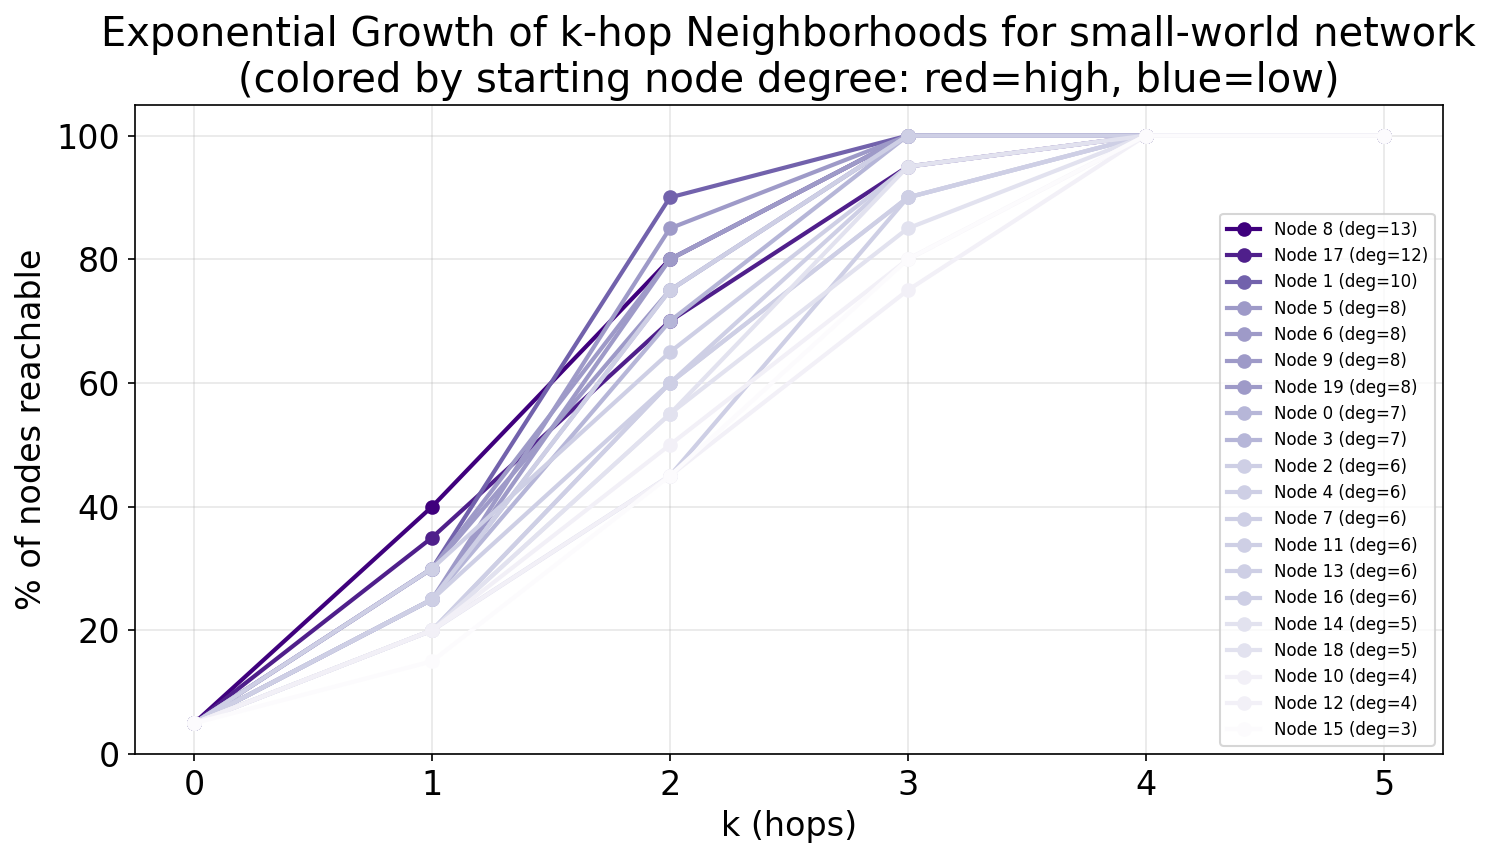

✓ Saved: fig_2_khop_growth_sw.png


In [10]:
# [FIGURE] k-hop growth curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

test_nodes = G_A.nodes

# Get degrees for coloring
degrees = G_A.degree()
max_degree = max(degrees, key=lambda x: x[1])[1]
min_degree = min(degrees, key=lambda x: x[1])[1]

# Create purple colormap (light to dark purple by degree)
cmap = plt.cm.Purples

# Sort nodes by degree (descending) for legend ordering
sorted_nodes = sorted(test_nodes, key=lambda n: dict(degrees)[n], reverse=True)

for start in sorted_nodes:
    reach = k_hop_reachability(G_A, start, max_k=5)
    ks = list(reach.keys())
    pcts = [reach[k] / G_A.number_of_nodes() * 100 for k in ks]
    
    # Color based on degree
    node_degree = degrees[start]
    color = cmap((node_degree - min_degree) / max(1, max_degree - min_degree))
    
    # Label with node number and degree
    label = f'Node {start} (deg={node_degree})'
    ax.plot(ks, pcts, 'o-', color=color, label=label, linewidth=2)

# ax.axhline(y=80, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('k (hops)')
ax.set_ylabel('% of nodes reachable')
ax.set_title('Exponential Growth of k-hop Neighborhoods for small-world network\n(colored by starting node degree: red=high, blue=low)')
ax.legend(loc='lower right', fontsize=8)
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('imgs/fig_2_khop_growth_sw.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved: fig_2_khop_growth_sw.png')

## 2.2 Real Connectome: Neighborhood Traversal

Now let's apply k-hop analysis to the real connectome data.


In [11]:
from tqdm import tqdm
# k-hop exploration on real connectome
print(f'Analyzing k-hop reachability in {DATASET} {REGION}:')

# Sample a few neurons to analyze
sample_neurons = np.random.choice(list(G_connectome.nodes()), size=100, replace=False)

pcts = []
for start in tqdm(sample_neurons):
    reach = k_hop_reachability(G_connectome, start, max_k=5)
    pct = [reach[k] / G_connectome.number_of_nodes() * 100 for k in range(1, 6)]
    pcts.append(pct)
pcts = np.array(pcts)

Analyzing k-hop reachability in fafb_783 central_complex:


100%|██████████| 100/100 [00:11<00:00,  8.49it/s]


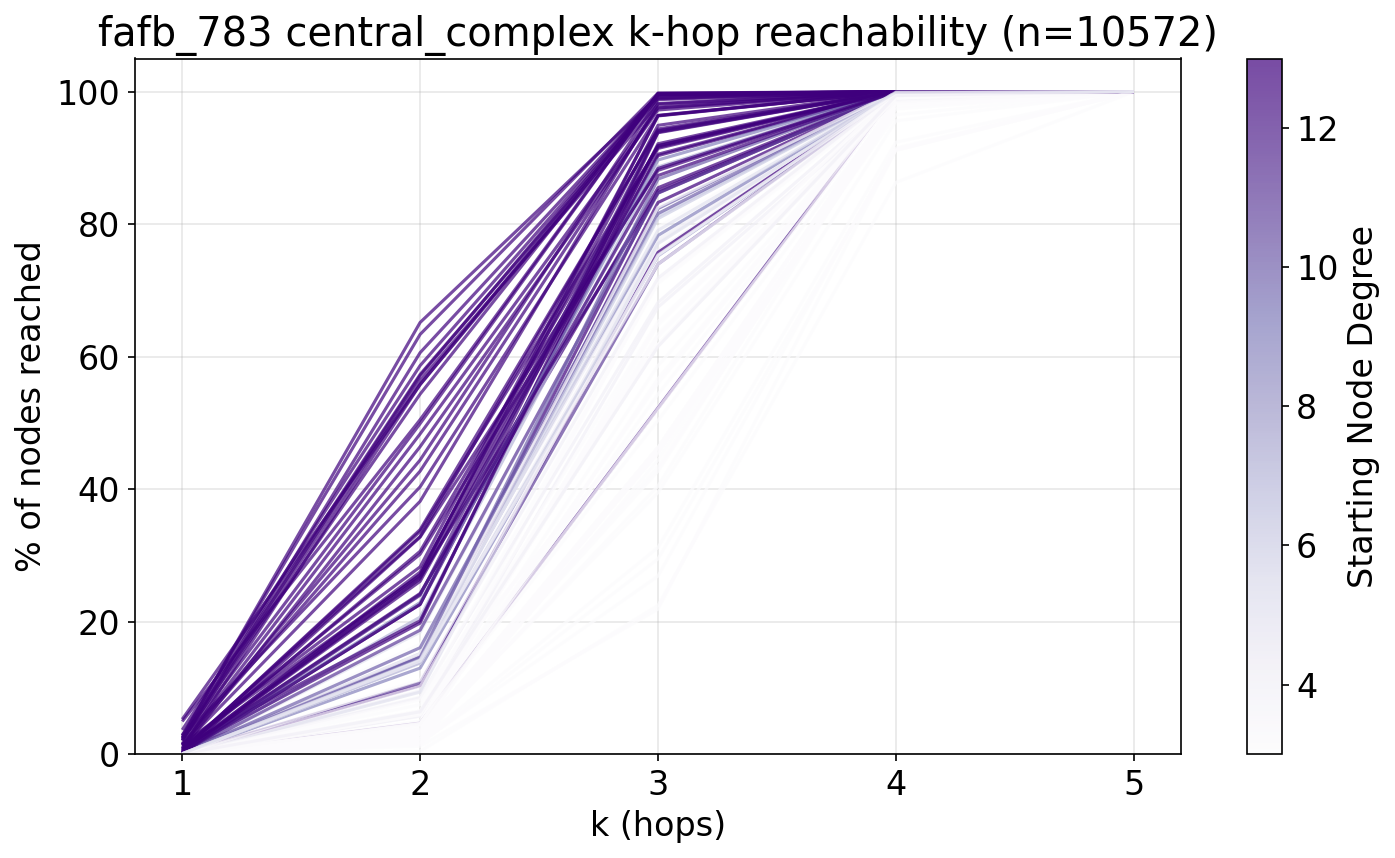

In [12]:
# [FIGURE] Compare k-hop growth: random network vs real connectome
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
# Create purple colormap (light to dark purple by degree)
cmap = plt.cm.Purples

ks = range(1, 6)
node_degree = np.array([deg for _, deg in G_connectome.degree(sample_neurons)])

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

segments = [np.column_stack([ks, pct]) for pct in pcts]
lc = LineCollection(segments, cmap=cmap, norm=Normalize(min_degree, max_degree))
lc.set_array(node_degree)
lc.set_alpha(0.7)
axes.add_collection(lc)
axes.autoscale()

axes.set_xlabel('k (hops)')
axes.set_ylabel('% of nodes reached')
axes.set_xticks(ks)
axes.set_title(f'{DATASET} {REGION} k-hop reachability (n={G_connectome.number_of_nodes()})')
axes.set_ylim(0, 105)
axes.grid(True, alpha=0.3)

plt.colorbar(lc, ax=axes, label='Starting Node Degree')

plt.tight_layout()
plt.savefig(f'imgs/fig2_khop_{DATASET}_{REGION}.png', dpi=150, bbox_inches='tight')
plt.show()


---
# PART 3: SPECTRAL EMBEDDING

Spectral embedding methods transform a graph's adjacency or Laplacian matrix into a low-dimensional vector space where each node is represented by a point.

**Methods covered:**
1. **ASE (Adjacency Spectral Embedding)**: Embeds based on adjacency matrix eigendecomposition
2. **LSE (Laplacian Spectral Embedding)**: Embeds based on graph Laplacian eigendecomposition

**Normalization approaches:**
- **None**: Raw adjacency matrix
- **Pass-to-rank (PTR)**: Rank-based normalization from graspologic
- **Row normalization**: Each row sums to 1 (out-degree normalized)
- **Column normalization**: Each column sums to 1 (in-degree normalized)

[pass-to-rank](https://github.com/graspologic-org/graspologic/blob/abc7fe0f59255bef20db281b95a5e3d23299167d/graspologic/utils/ptr.py#L11) doc from [graspologic](https://graspologic-org.github.io/graspologic/):
    method: {'simple-nonzero' (default), 'simple-all', 'zero-boost'} string, optional

        - 'simple-nonzero'
            assigns ranks to all non-zero edges, settling ties using
            the average. Ranks are then scaled by
            :math:`\\frac{rank(\\text{non-zero edges})}{\\text{total non-zero edges} + 1}`
        - 'simple-all'
            assigns ranks to all non-zero edges, settling ties using
            the average. Ranks are then scaled by
            :math:`\\frac{rank(\\text{non-zero edges})}{n^2 + 1}`
            where n is the number of nodes
        - 'zero-boost'
            preserves the edge weight for all 0s, but ranks the other
            edges as if the ranks of all 0 edges has been assigned. If there are
            10 0-valued edges, the lowest non-zero edge gets weight 11 / (number
            of possible edges). Ties settled by the average of the weight that those
            edges would have received. Number of possible edges is determined
            by the type of graph (loopless or looped, directed or undirected).

In [13]:
# Spectral embedding imports
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed
from graspologic.utils import pass_to_ranks

print('✓ Spectral embedding imports successful!')

✓ Spectral embedding imports successful!


In [14]:
def get_adjacency_variants(G):
    """
    Generate different normalization variants of the adjacency matrix.
    
    Parameters
    ----------
    G : nx.DiGraph
        Input graph
    
    Returns
    -------
    dict
        Dictionary of {name: adjacency_matrix} for each normalization
    """
    # Get raw adjacency matrix
    nodes = list(G.nodes())
    A = nx.adjacency_matrix(G, nodelist=nodes).astype(float)
    A_dense = A.toarray()
    
    variants = {}
    
    # 1. No normalization (raw)
    variants['none'] = A_dense
    
    # 2. Pass-to-rank normalization
    variants['pass_to_ranks'] = pass_to_ranks(A_dense)
    
    # 3. Row normalization (out-degree)
    row_sums = A_dense.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    variants['row_norm'] = A_dense / row_sums
    
    # 4. Column normalization (in-degree)
    col_sums = A_dense.sum(axis=0, keepdims=True)
    col_sums[col_sums == 0] = 1  # Avoid division by zero
    variants['col_norm'] = A_dense / col_sums
    
    return variants, nodes

# Test on small graph
variants_test, _ = get_adjacency_variants(G_A)
print('Adjacency matrix variants:')
for name, A in variants_test.items():
    print(f'  {name}: shape={A.shape}, range=[{A.min():.3f}, {A.max():.3f}]')

Adjacency matrix variants:
  none: shape=(20, 20), range=[0.000, 10.000]
  pass_to_ranks: shape=(20, 20), range=[0.000, 0.957]
  row_norm: shape=(20, 20), range=[0.000, 0.900]
  col_norm: shape=(20, 20), range=[0.000, 1.000]


In [15]:
def compute_spectral_embeddings(A, n_components=50, methods=['ASE', 'LSE']):
    """
    Compute spectral embeddings using ASE and/or LSE.
    
    Parameters
    ----------
    A : ndarray
        Adjacency matrix (can be any normalization)
    n_components : int
        Number of embedding dimensions
    methods : list
        List of methods to use: ['ASE'], ['LSE'], or ['ASE', 'LSE']
    
    Returns
    -------
    dict
        Dictionary of {method: embedding} where embedding is (Xhat, Yhat) for directed graphs
    """
    results = {}
    
    if 'ASE' in methods:
        ase = AdjacencySpectralEmbed(n_components=n_components, diag_aug=True)
        try:
            embedding = ase.fit_transform(A)
            if isinstance(embedding, tuple):
                Xhat, Yhat = embedding
            else:
                Xhat, Yhat = embedding, embedding
            results['ASE'] = {'Xhat': Xhat, 'Yhat': Yhat, 'combined': np.concatenate([Xhat, Yhat], axis=1)}
        except Exception as e:
            print(f'ASE failed: {e}')
            results['ASE'] = None
    
    if 'LSE' in methods:
        lse = LaplacianSpectralEmbed(n_components=n_components)
        try:
            embedding = lse.fit_transform(A)
            if isinstance(embedding, tuple):
                Xhat, Yhat = embedding
            else:
                Xhat, Yhat = embedding, embedding
            results['LSE'] = {'Xhat': Xhat, 'Yhat': Yhat, 'combined': np.concatenate([Xhat, Yhat], axis=1)}
        except Exception as e:
            print(f'LSE failed: {e}')
            results['LSE'] = None
    
    return results

print('✓ Spectral embedding function defined')

✓ Spectral embedding function defined


In [16]:
# Compute embeddings for connectome with different normalizations
print('=' * 80)
print('SPECTRAL EMBEDDING: Connectome with Different Normalizations')
print('=' * 80)

N_COMPONENTS = 2  # Number of embedding dimensions

# Get adjacency variants
variants, nodes = get_adjacency_variants(G_connectome)
print(f'\nConnectome: {len(nodes)} nodes')
print(f'Embedding dimensions: {N_COMPONENTS}')

# Store all embeddings
all_embeddings = {}

for norm_name, A in variants.items():
    print(f'\n--- {norm_name.upper()} normalization ---')
    
    embeddings = compute_spectral_embeddings(A, n_components=N_COMPONENTS)
    all_embeddings[norm_name] = embeddings
    
    for method, emb in embeddings.items():
        if emb is not None:
            print(f'  {method}: Xhat={emb["Xhat"].shape}, Yhat={emb["Yhat"].shape}, combined={emb["combined"].shape}')

print('\n' + '=' * 80)
print('✓ All embeddings computed!')
print('=' * 80)

SPECTRAL EMBEDDING: Connectome with Different Normalizations

Connectome: 10572 nodes
Embedding dimensions: 2

--- NONE normalization ---
  ASE: Xhat=(10572, 2), Yhat=(10572, 2), combined=(10572, 4)
  LSE: Xhat=(10572, 2), Yhat=(10572, 2), combined=(10572, 4)

--- PASS_TO_RANKS normalization ---
  ASE: Xhat=(10572, 2), Yhat=(10572, 2), combined=(10572, 4)
  LSE: Xhat=(10572, 2), Yhat=(10572, 2), combined=(10572, 4)

--- ROW_NORM normalization ---
  ASE: Xhat=(10572, 2), Yhat=(10572, 2), combined=(10572, 4)
  LSE: Xhat=(10572, 2), Yhat=(10572, 2), combined=(10572, 4)

--- COL_NORM normalization ---
  ASE: Xhat=(10572, 2), Yhat=(10572, 2), combined=(10572, 4)
  LSE: Xhat=(10572, 2), Yhat=(10572, 2), combined=(10572, 4)

✓ All embeddings computed!


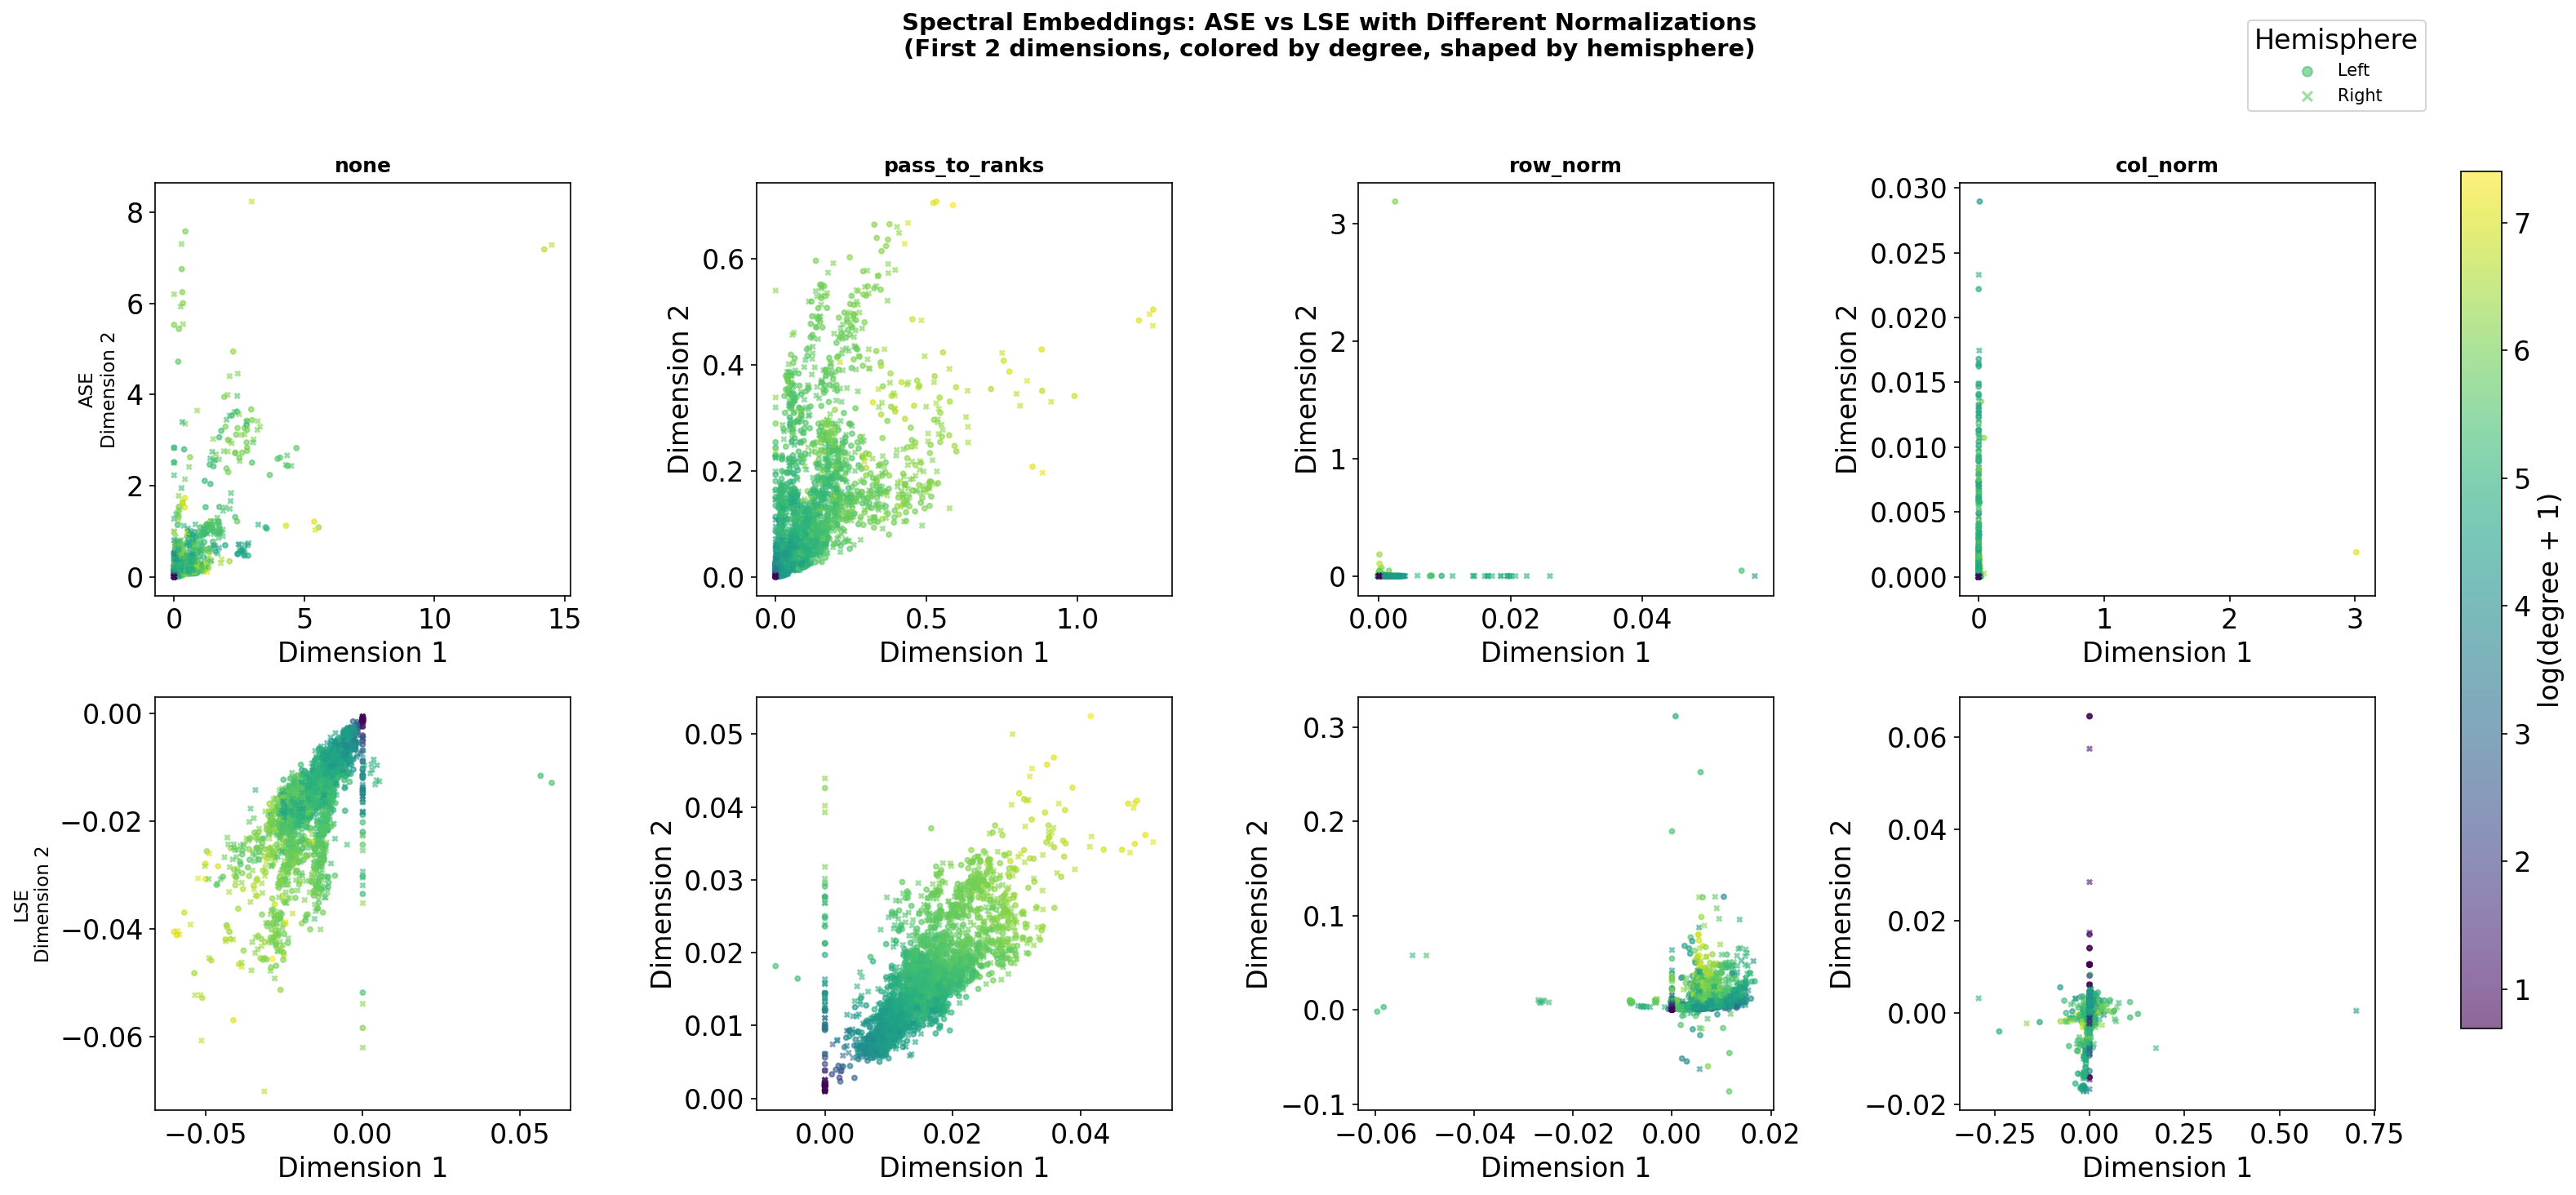


✓ Saved: imgs/fig_spectral_embeddings_comparison.png


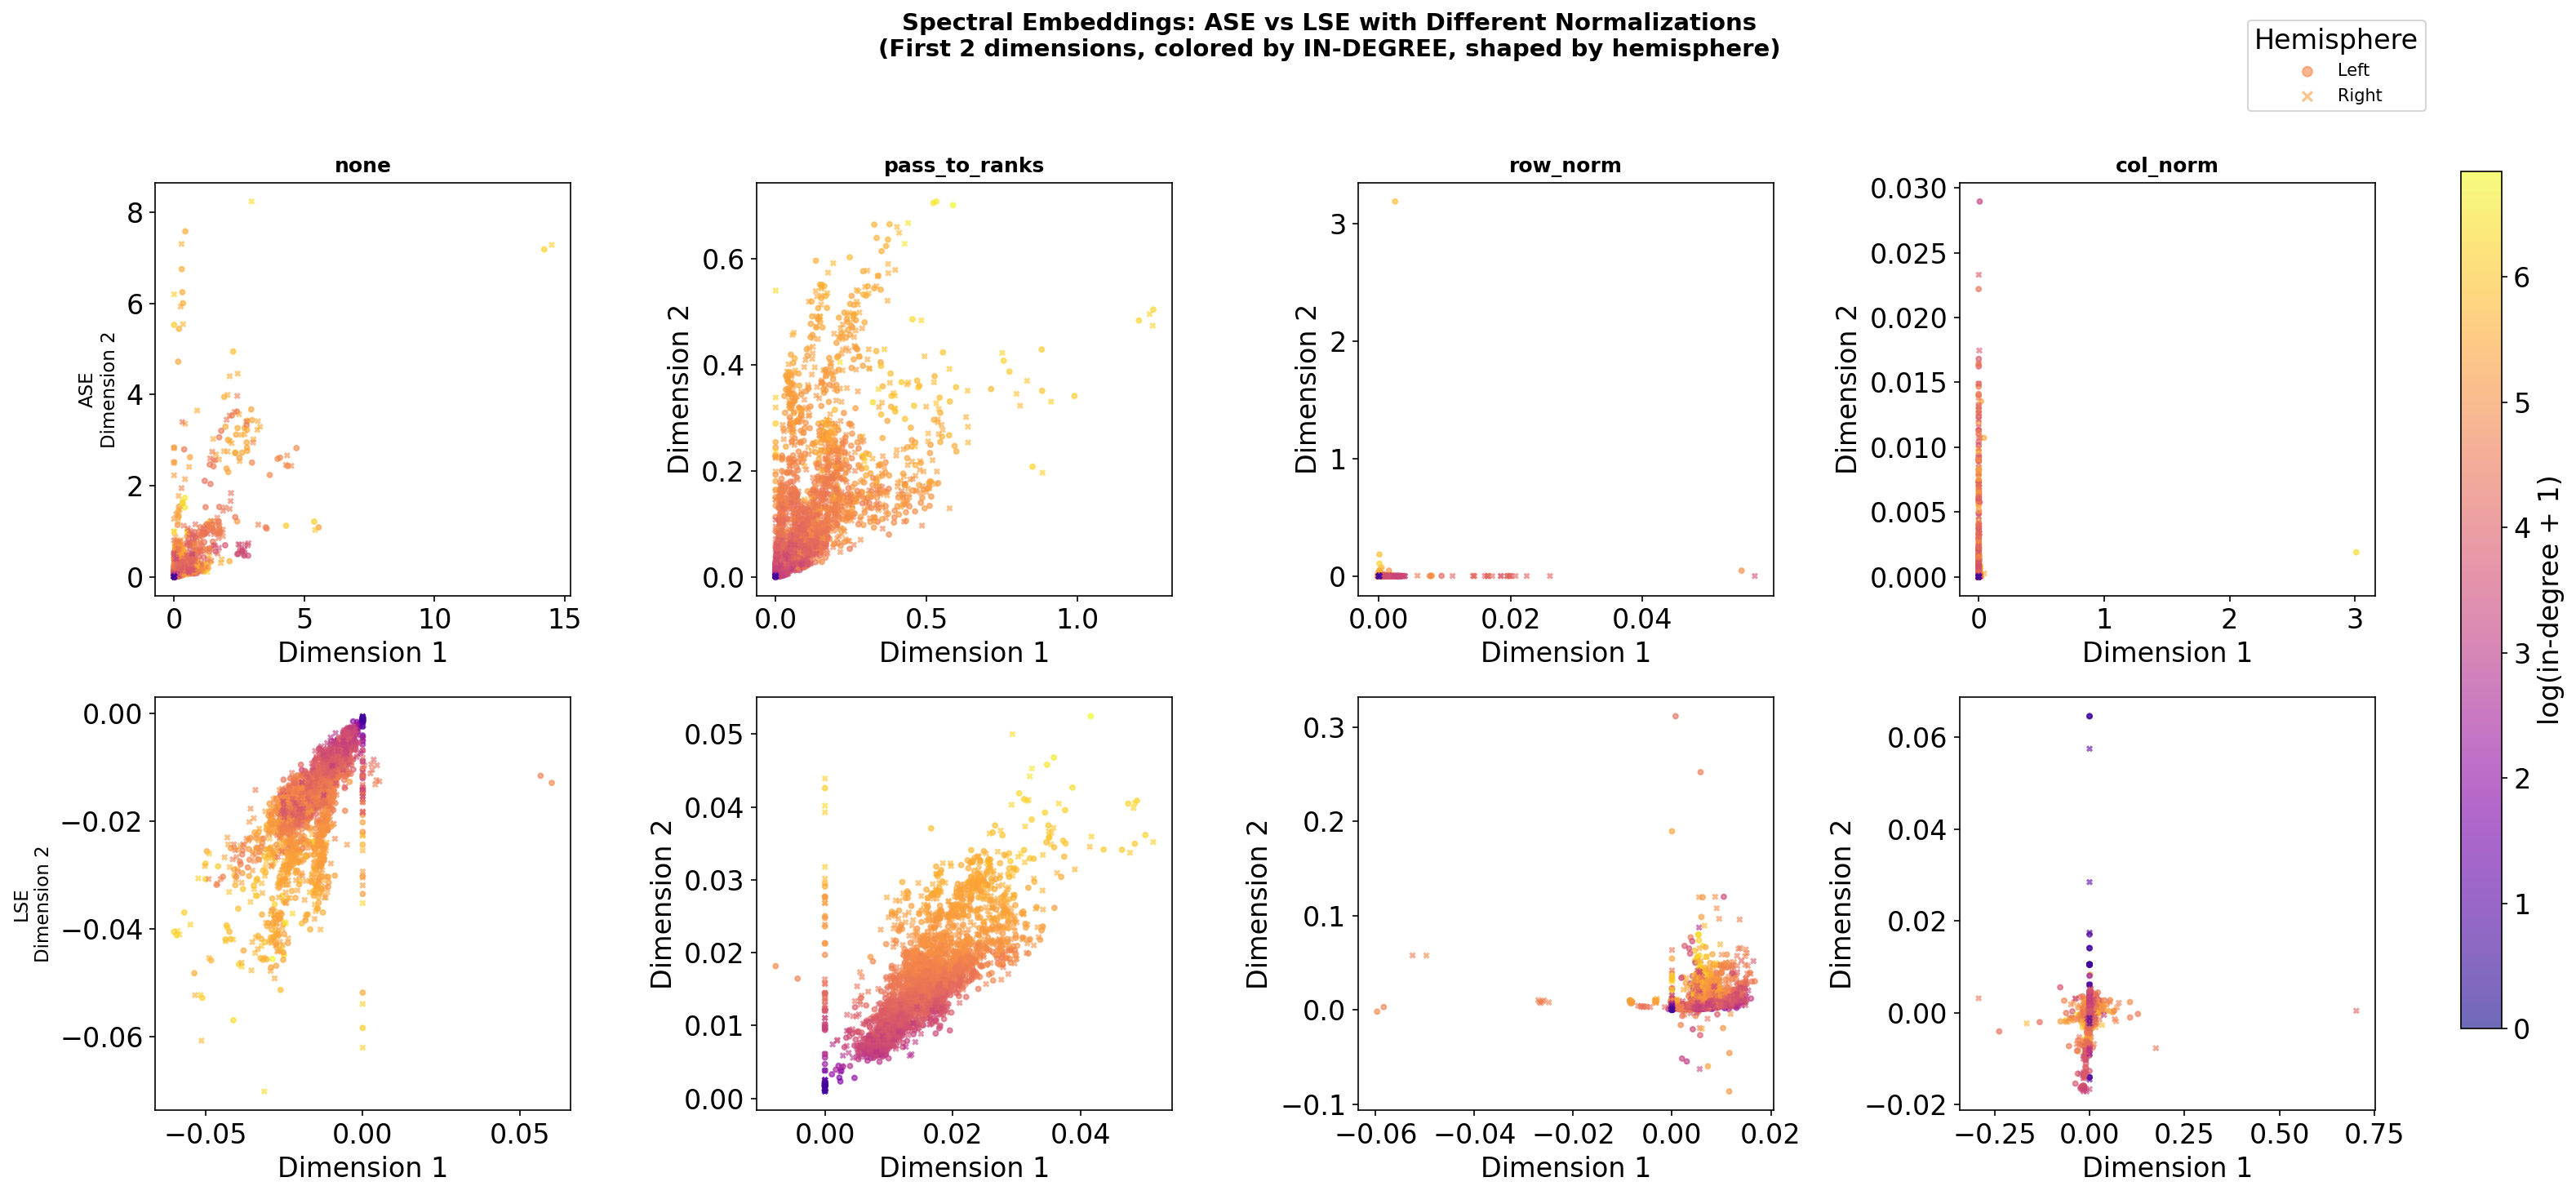


✓ Saved: imgs/fig_spectral_embeddings_in_degree.png


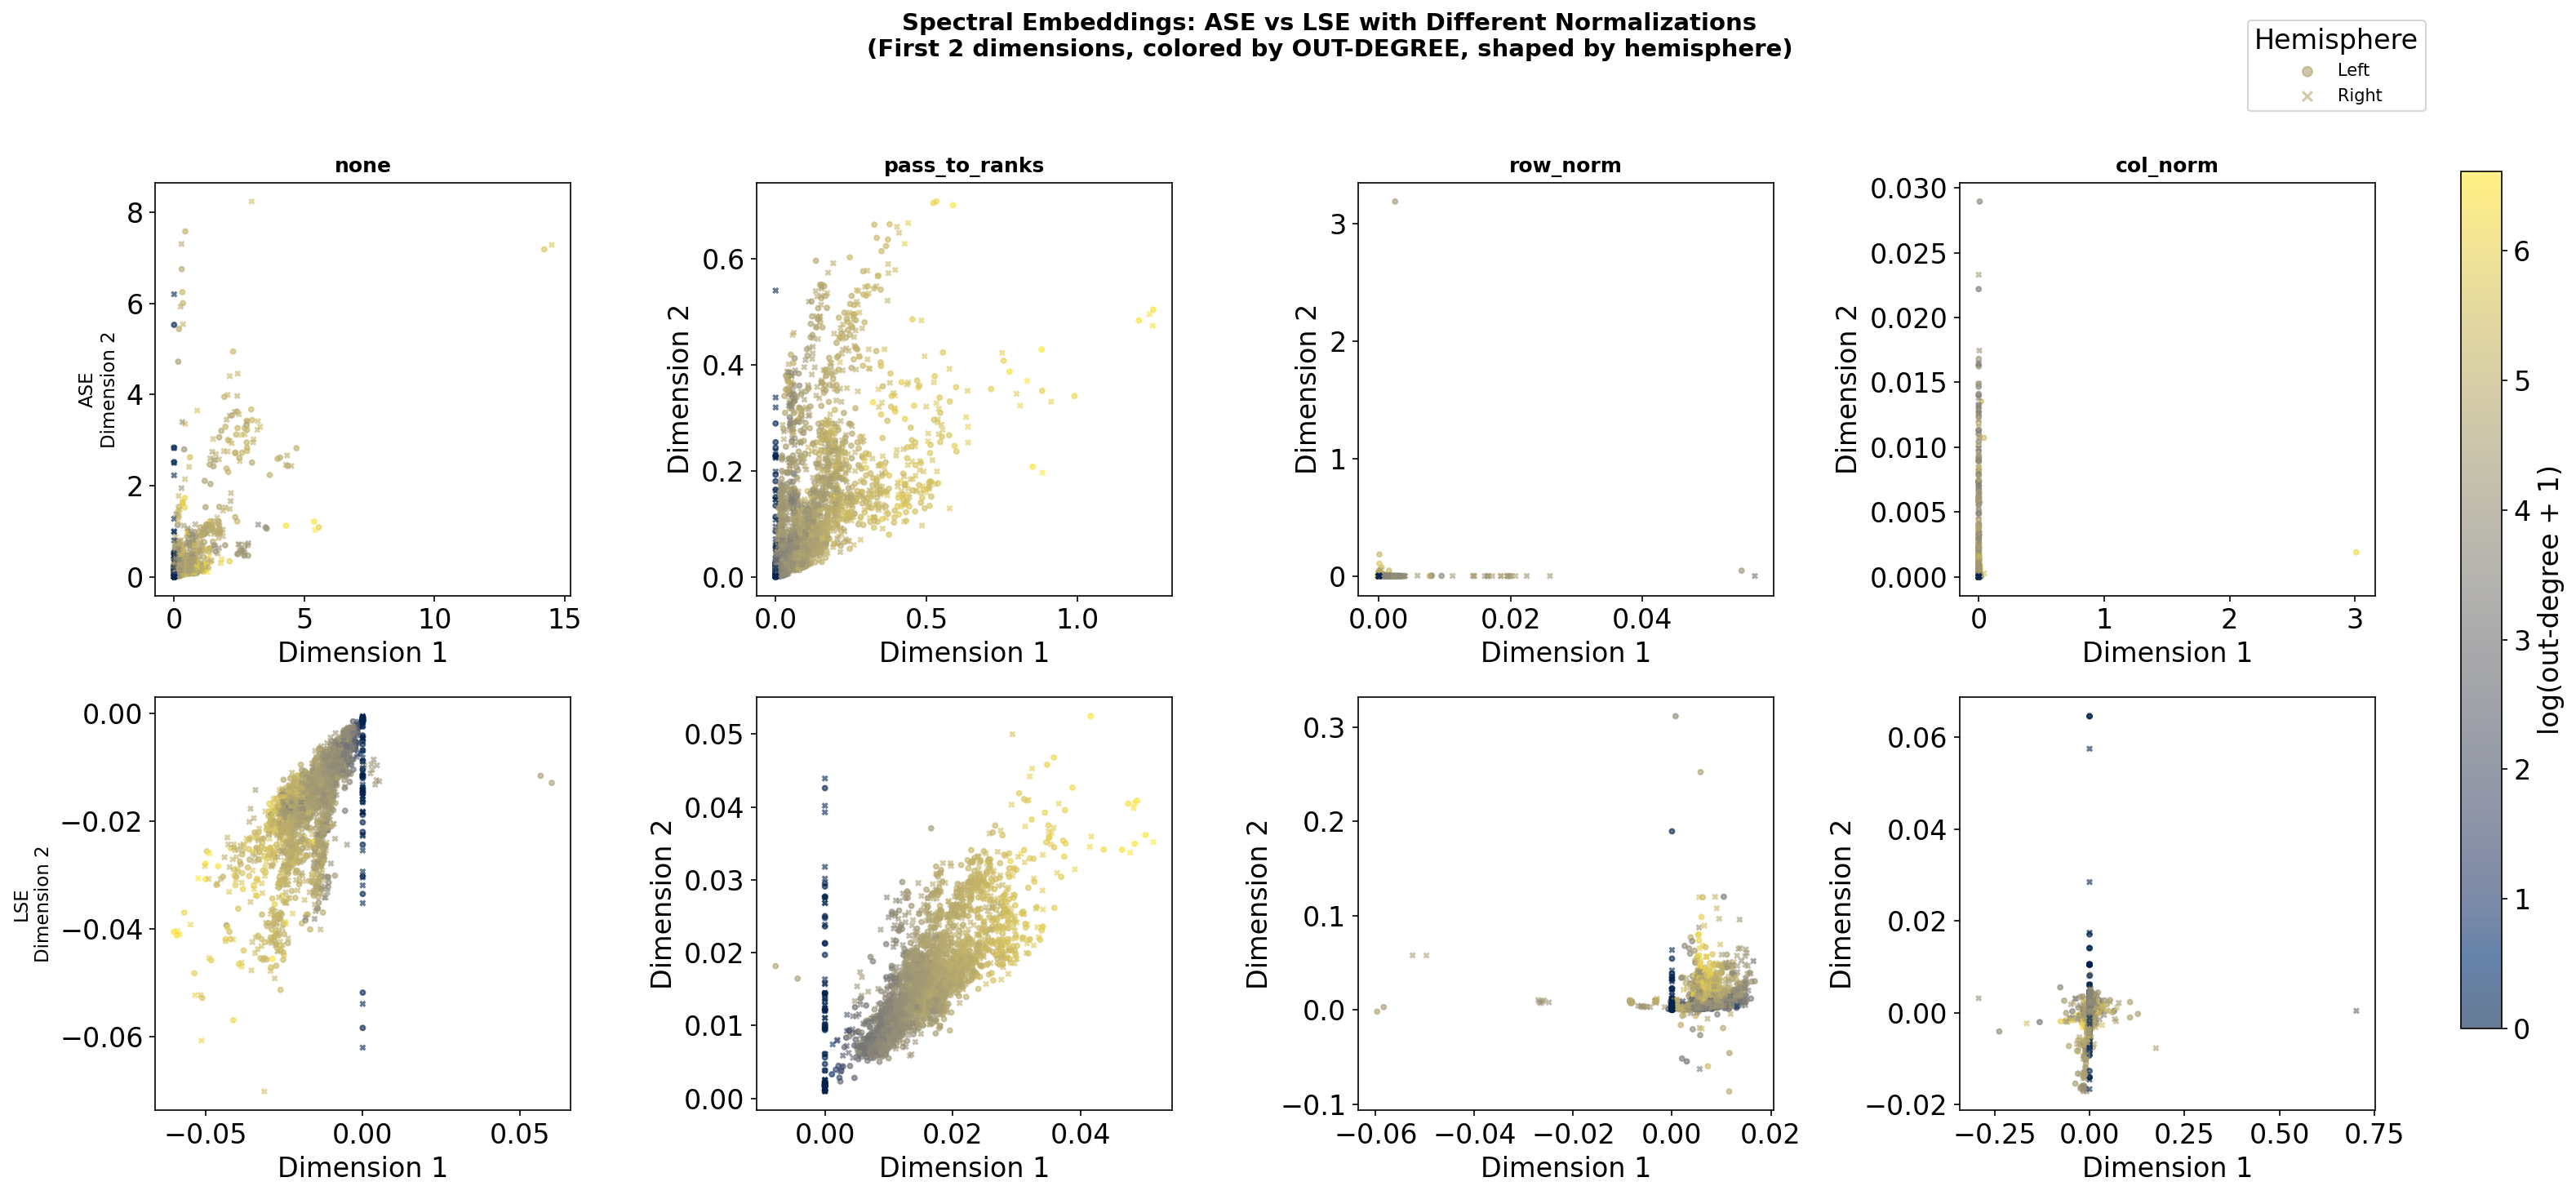


✓ Saved: imgs/fig_spectral_embeddings_out_degree.png


In [17]:
# [FIGURE] Compare first 2 dimensions of ASE across normalizations
fig, axes = plt.subplots(2, 4, figsize=(22, 10))

norm_names = list(all_embeddings.keys())
methods = ['ASE', 'LSE']

# Color by degree for visualization
degrees = np.array([G_connectome.degree(n) for n in nodes])
degree_colors = np.log1p(degrees)  # Log scale for better visualization

# Get hemisphere (side) for each node - use different markers
sides = np.array([G_connectome.nodes[n].get('side', None) for n in nodes])
side_markers = {'left': 'o', 'right': 'x'}  # circle vs X - very distinct
side_labels = {'left': 'Left', 'right': 'Right'}

# Create masks for each hemisphere (exclude None/unknown)
side_masks = {side: sides == side for side in side_markers.keys()}

for row_idx, method in enumerate(methods):
    for col_idx, norm_name in enumerate(norm_names):
        ax = axes[row_idx, col_idx]
        
        emb = all_embeddings[norm_name].get(method)
        if emb is not None:
            X = np.concatenate([emb['Xhat'][:, 0:1], emb['Yhat'][:, 0:1]], axis=1)
            
            # Plot each hemisphere with different marker (skip unknowns)
            for side, mask in side_masks.items():
                if mask.sum() > 0:
                    sc = ax.scatter(X[mask, 0], X[mask, 1], 
                                   c=degree_colors[mask], 
                                   cmap='viridis', s=8, alpha=0.6,
                                   marker=side_markers[side],
                                   label=side_labels[side],
                                   vmin=degree_colors.min(), vmax=degree_colors.max())
            
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
        else:
            ax.text(0.5, 0.5, 'Failed', ha='center', va='center', transform=ax.transAxes)
        
        if row_idx == 0:
            ax.set_title(f'{norm_name}', fontsize=12, fontweight='bold')
        if col_idx == 0:
            ax.set_ylabel(f'{method}\nDimension 2', fontsize=11)

# Add colorbar on the far right, outside all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sc, cax=cbar_ax, label='log(degree + 1)')

# Add legend for hemisphere markers
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.91, 0.98), 
           title='Hemisphere', fontsize=10, markerscale=2)

plt.suptitle('Spectral Embeddings: ASE vs LSE with Different Normalizations\n(First 2 dimensions, colored by degree, shaped by hemisphere)',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 0.91, 0.95])
plt.savefig('imgs/fig_spectral_embeddings_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Saved: imgs/fig_spectral_embeddings_comparison.png')

# [FIGURE] Same plot but colored by IN-DEGREE
fig, axes = plt.subplots(2, 4, figsize=(22, 10))

# Color by in-degree
in_degrees = np.array([G_connectome.in_degree(n) for n in nodes])
in_degree_colors = np.log1p(in_degrees)

for row_idx, method in enumerate(methods):
    for col_idx, norm_name in enumerate(norm_names):
        ax = axes[row_idx, col_idx]
        
        emb = all_embeddings[norm_name].get(method)
        if emb is not None:
            X = np.concatenate([emb['Xhat'][:, 0:1], emb['Yhat'][:, 0:1]], axis=1)
            
            for side, mask in side_masks.items():
                if mask.sum() > 0:
                    sc = ax.scatter(X[mask, 0], X[mask, 1], 
                                   c=in_degree_colors[mask], 
                                   cmap='plasma', s=8, alpha=0.6,
                                   marker=side_markers[side],
                                   label=side_labels[side],
                                   vmin=in_degree_colors.min(), vmax=in_degree_colors.max())
            
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
        else:
            ax.text(0.5, 0.5, 'Failed', ha='center', va='center', transform=ax.transAxes)
        
        if row_idx == 0:
            ax.set_title(f'{norm_name}', fontsize=12, fontweight='bold')
        if col_idx == 0:
            ax.set_ylabel(f'{method}\nDimension 2', fontsize=11)

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax, label='log(in-degree + 1)')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.91, 0.98), 
           title='Hemisphere', fontsize=10, markerscale=2)

plt.suptitle('Spectral Embeddings: ASE vs LSE with Different Normalizations\n(First 2 dimensions, colored by IN-DEGREE, shaped by hemisphere)',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 0.91, 0.95])
plt.savefig('imgs/fig_spectral_embeddings_in_degree.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Saved: imgs/fig_spectral_embeddings_in_degree.png')

# [FIGURE] Same plot but colored by OUT-DEGREE
fig, axes = plt.subplots(2, 4, figsize=(22, 10))

# Color by out-degree
out_degrees = np.array([G_connectome.out_degree(n) for n in nodes])
out_degree_colors = np.log1p(out_degrees)

for row_idx, method in enumerate(methods):
    for col_idx, norm_name in enumerate(norm_names):
        ax = axes[row_idx, col_idx]
        
        emb = all_embeddings[norm_name].get(method)
        if emb is not None:
            X = np.concatenate([emb['Xhat'][:, 0:1], emb['Yhat'][:, 0:1]], axis=1)
            
            for side, mask in side_masks.items():
                if mask.sum() > 0:
                    sc = ax.scatter(X[mask, 0], X[mask, 1], 
                                   c=out_degree_colors[mask], 
                                   cmap='cividis', s=8, alpha=0.6,
                                   marker=side_markers[side],
                                   label=side_labels[side],
                                   vmin=out_degree_colors.min(), vmax=out_degree_colors.max())
            
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
        else:
            ax.text(0.5, 0.5, 'Failed', ha='center', va='center', transform=ax.transAxes)
        
        if row_idx == 0:
            ax.set_title(f'{norm_name}', fontsize=12, fontweight='bold')
        if col_idx == 0:
            ax.set_ylabel(f'{method}\nDimension 2', fontsize=11)

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax, label='log(out-degree + 1)')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.91, 0.98), 
           title='Hemisphere', fontsize=10, markerscale=2)

plt.suptitle('Spectral Embeddings: ASE vs LSE with Different Normalizations\n(First 2 dimensions, colored by OUT-DEGREE, shaped by hemisphere)',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 0.91, 0.95])
plt.savefig('imgs/fig_spectral_embeddings_out_degree.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✓ Saved: imgs/fig_spectral_embeddings_out_degree.png')

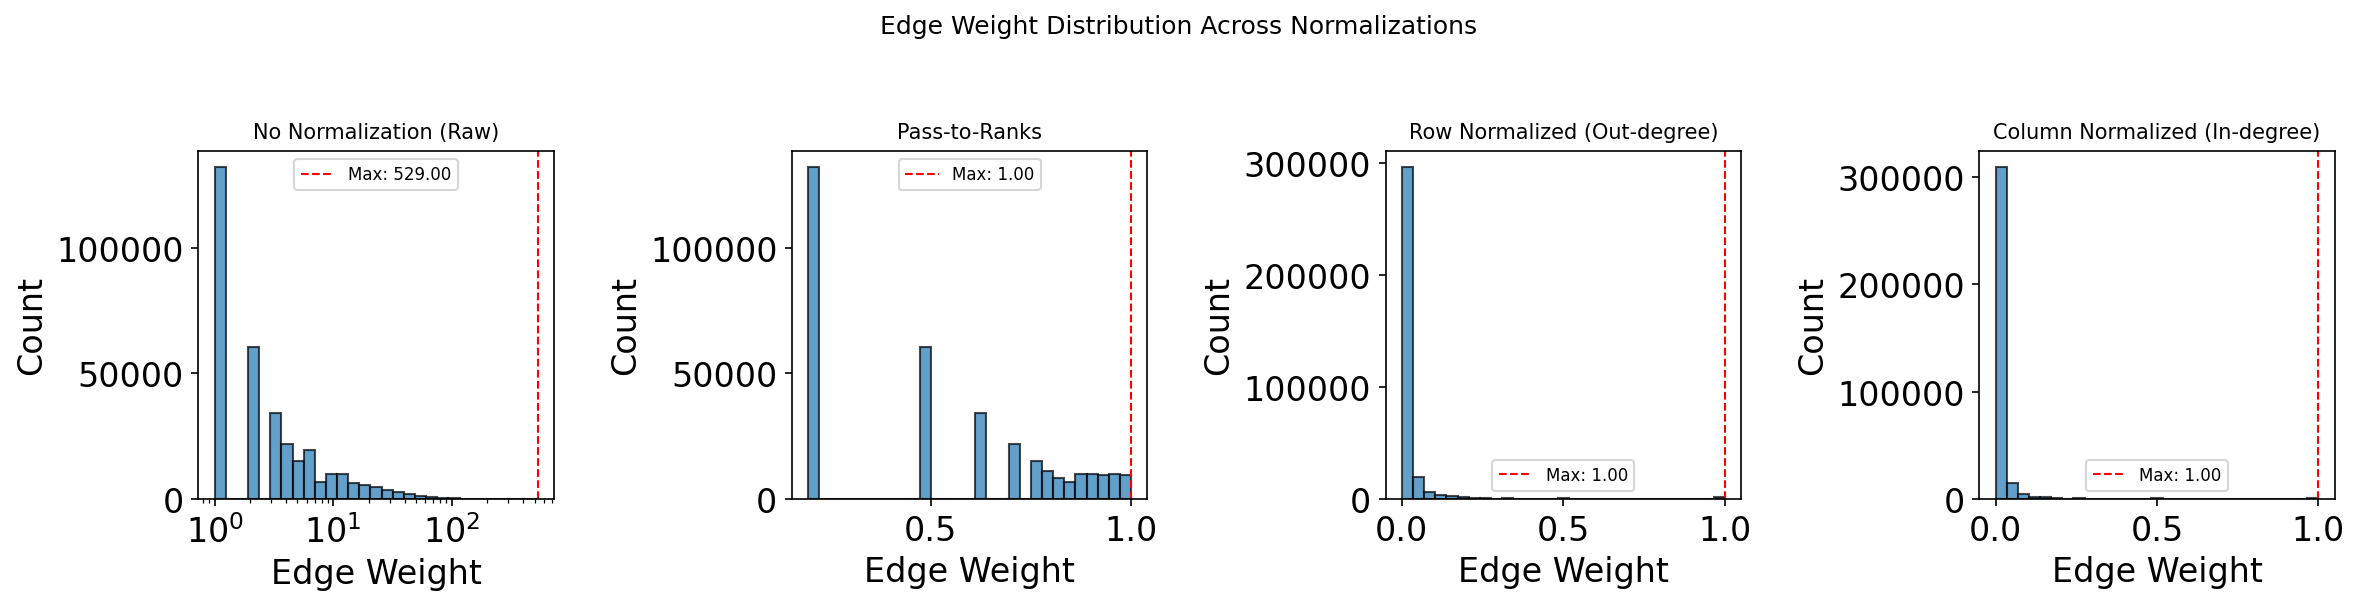


Weight Distribution Summary:
Normalization                    Min        Max       Mean     Median
--------------------------------------------------------------------------------
none                          1.0000   529.0000     5.3525     2.0000
pass_to_ranks                 0.1941     1.0000     0.5000     0.4774
row_norm                      0.0001     1.0000     0.0282     0.0052
col_norm                      0.0001     1.0000     0.0207     0.0043


In [18]:
import matplotlib.pyplot as plt

# Get adjacency variants for the connectome
variants, nodes = get_adjacency_variants(G_connectome)

# Plot weight distributions for all 4 normalizations
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

titles = {
    'none': 'No Normalization (Raw)',
    'pass_to_ranks': 'Pass-to-Ranks',
    'row_norm': 'Row Normalized (Out-degree)',
    'col_norm': 'Column Normalized (In-degree)'
}

for ax, (name, A) in zip(axes, variants.items()):
    # Get non-zero weights
    weights = A[A > 0].flatten()
    
    if name == 'none':
        # Log-scale bins for raw weights
        bins = np.geomspace(weights.min(), weights.max(), 30)
        ax.set_xscale('log')
    else:
        # Linear bins for normalized weights
        bins = np.linspace(weights.min(), weights.max(), 30)
    
    ax.hist(weights, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Edge Weight')
    ax.set_ylabel('Count')
    ax.set_title(titles[name], fontsize=10)
    
    # Add max indicator
    ax.axvline(weights.max(), color='red', linestyle='--', linewidth=1, label=f'Max: {weights.max():.2f}')
    ax.legend(fontsize=8)

plt.suptitle('Edge Weight Distribution Across Normalizations', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print('\nWeight Distribution Summary:')
print('=' * 80)
print(f"{'Normalization':<25} {'Min':>10} {'Max':>10} {'Mean':>10} {'Median':>10}")
print('-' * 80)
for name, A in variants.items():
    weights = A[A > 0].flatten()
    print(f"{name:<25} {weights.min():>10.4f} {weights.max():>10.4f} {np.mean(weights):>10.4f} {np.median(weights):>10.4f}")
print('=' * 80)

## 3.1 Key Takeaways: Spectral Embedding

**Normalization matters:**
- **None**: Preserves raw connection strengths; high-degree nodes dominate
- **Pass-to-ranks**: Robust to outliers; recommended for most connectome analyses
- **Row normalization**: Emphasizes outgoing connection patterns
- **Column normalization**: Emphasizes incoming connection patterns

More in 02_community_detection.ipynb! 